<font size=6><b>Прогнозирование количества заказов такси</b></font>

<b>Описание проекта</b><br>
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.<br>
<b>Цель</b><br>
Построить модель для такого предсказания. Значение метрики RMSE на тестовой выборке должно быть не больше 48.<br>
<b>План</b>:<br>
1. Загрузить данные;
2. Ресеплирование;
3. Создание признаков;
4. Анализ признаков;
5. Разделение выборки;
6. Масштабирование признаков;
7. Подбор гиперпараметров;
8. Обучение моделей;
9. Определение качества моделей;
10. Выбор лучшей модели;
11. Проверка лучшей модели на тестовой выборке;
12. Выводы.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных-и-ресемплирование" data-toc-modified-id="Загрузка-данных-и-ресемплирование-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных и ресемплирование</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Разделение-выборки" data-toc-modified-id="Разделение-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Разделение выборки</a></span></li><li><span><a href="#Подбор-гиперпараметров-и-оценка-качества" data-toc-modified-id="Подбор-гиперпараметров-и-оценка-качества-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подбор гиперпараметров и оценка качества</a></span></li></ul></li><li><span><a href="#Проверка-модели" data-toc-modified-id="Проверка-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Загрузка данных и ресемплирование

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
RSTATE = 70707

In [3]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Исходные данные: 26496 записей (1 марта 2018 года по 31 августа 2018 года), шаг - 10 минут.

Сделаем ресемплирование данных по одному часу.

In [5]:
df = df.resample('1H').sum()

In [6]:
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ данных

Построим график изменения количества заказов такси во времени.

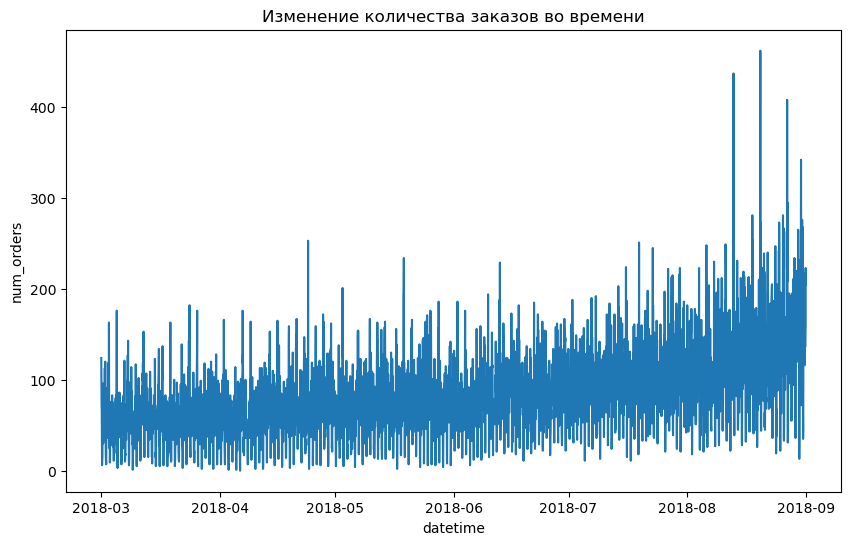

In [7]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=df.index, y=df['num_orders']).set(title='Изменение количества заказов во времени');

Уже по этому графику видно, что количество заказов растёт.

Построим гистограмму.

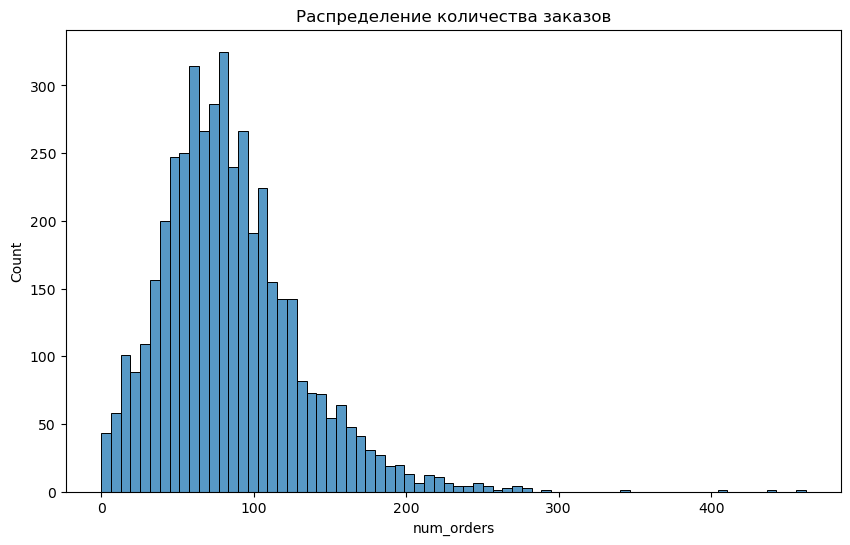

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['num_orders']).set(title='Распределение количества заказов');

Распределение должно хорошо описываться распределением Пуассона, приближающимся к нормальному. Заметен длинный правый хвост.

Сделаем декомпозицию изменения количества заказов во времени.

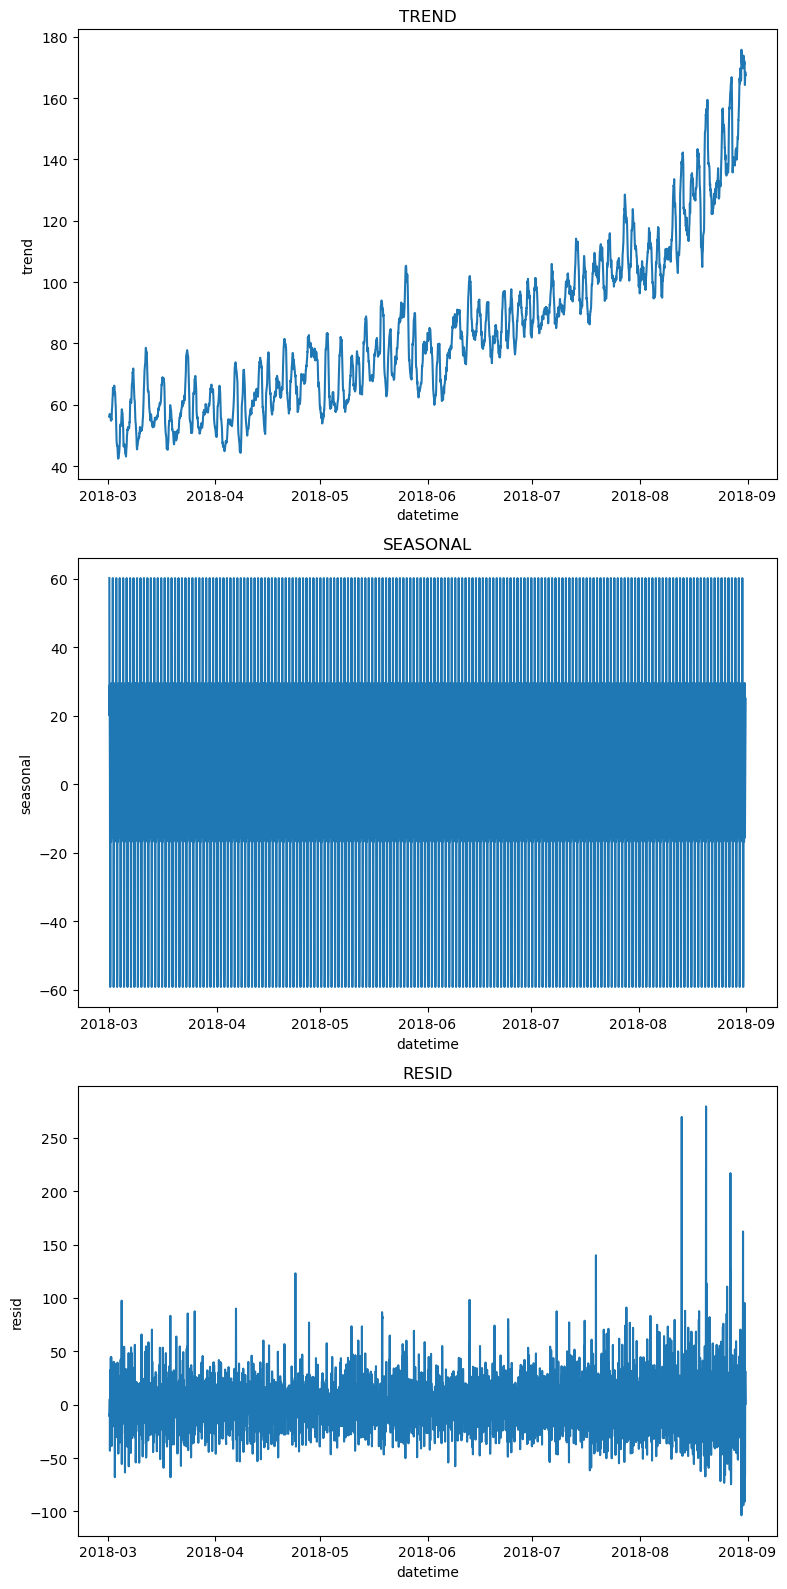

In [9]:
num_orders_decomp = seasonal_decompose(df['num_orders'])
decomp = num_orders_decomp.trend, num_orders_decomp.seasonal, num_orders_decomp.resid

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 16))
for i, ax in enumerate(axes):
    sns.lineplot(ax=ax, x=df.index, y=decomp[i])
    ax.set_title(f'{decomp[i].name.upper()}')
plt.tight_layout()
plt.show()

На декомпозиции хорошо заметен тренд; периодичность сезонности связана, вероятно, с суточными изменениями; есть "случайные выбросы" в августе.

Создадим дополнительные признаки.

Так как год только один (2018), и нам при этом важно, в какое время суток происходят заказы такси, то создадим следующие признаки: месяц, день, день недели, час.

In [10]:
# функция создаёт признаки: календарные, "отстающие", скользящее среднее
def make_features(df, n_lags=0, n_roll=0):
    # календарные
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    # "отстающие"
    if n_lags > 0:
        for i in range(1, n_lags + 1):
            df[f'lag_{i}'] = df['num_orders'].shift(i)
    # скользящее среднее (со сдвигом, чтобы не "смотреть в будущее")
    if n_roll > 0:
        df[f'rolling_mean_{n_roll}'] = df['num_orders'].shift().rolling(n_roll).mean()

In [11]:
make_features(df)#, n_lags=3, n_roll=7)
df.head(10)

,num_orders,month,day,dayofweek,hour
datetime,,,,,
2018-03-01 00:00:00,124,3,1,3,0
2018-03-01 01:00:00,85,3,1,3,1
2018-03-01 02:00:00,71,3,1,3,2
2018-03-01 03:00:00,66,3,1,3,3
2018-03-01 04:00:00,43,3,1,3,4
2018-03-01 05:00:00,6,3,1,3,5
2018-03-01 06:00:00,12,3,1,3,6
2018-03-01 07:00:00,15,3,1,3,7
2018-03-01 08:00:00,34,3,1,3,8


Рассмотрим зависимость количества заказов от месяца, дня, дня недели и часа.

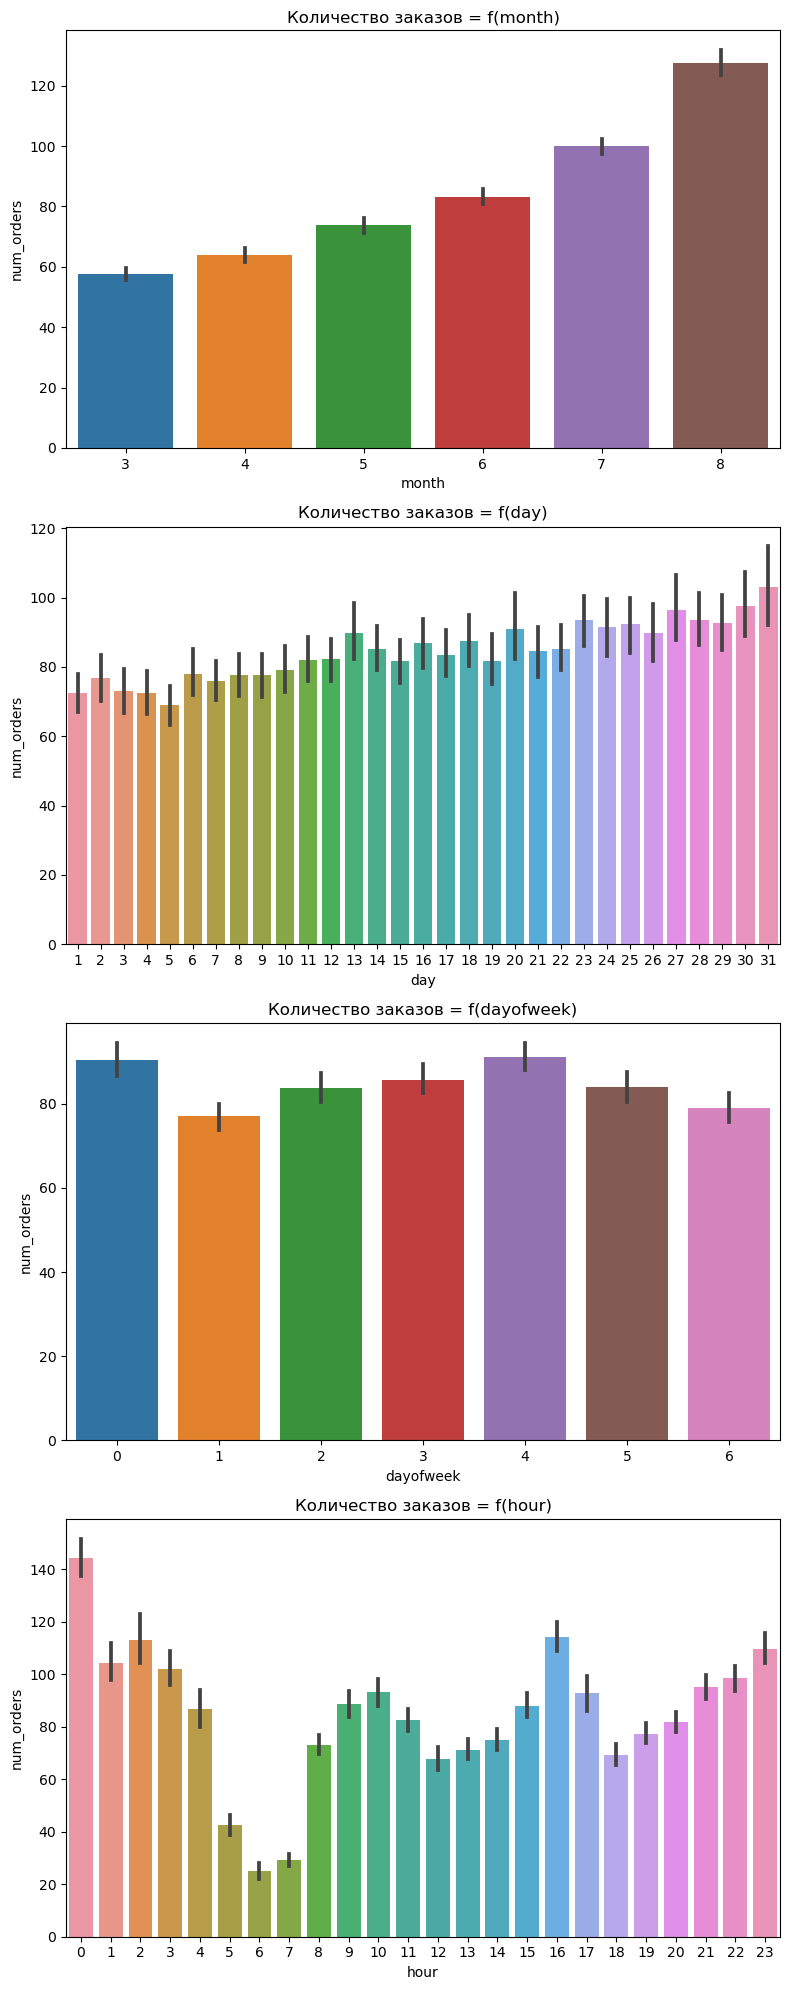

In [12]:
cols = df.columns[1:5]
fig, axes = plt.subplots(nrows=len(cols), ncols=1, figsize=(8, 20))
for i, ax in enumerate(axes):
    sns.barplot(ax=ax, x=df[cols[i]], y=df['num_orders'])
    ax.set_title(f'Количество заказов = f({cols[i]})')
plt.tight_layout()
plt.show()

На графиках видно:
* количество заказов растёт от месяца к месяцу;
* есть небольшое различие между первыми числами месяца и последними;
* от дня недели количество заказов не зависит;
* количество заказов такси растёт к ночи, есть заметные пики в районе 9-10 часов и 16-17 часов (утренний и вечерний час пик), также заметен резкий спад ранним утром (вероятно, просто в это время нет самолётов).

Построим матрицу корреляции.

In [13]:
df.corr().style.background_gradient(vmin=-1, vmax=1, cmap='Spectral')

,num_orders,month,day,dayofweek,hour
num_orders,1.000000,0.510108,0.165312,-0.019628,0.004292
month,0.510108,1.000000,0.005433,-0.011962,0.000000
day,0.165312,0.005433,1.000000,-0.013827,0.000000
dayofweek,-0.019628,-0.011962,-0.013827,1.000000,0.000000
hour,0.004292,0.000000,0.000000,0.000000,1.000000


Прослеживается средняя взаимосвязь между количеством заказов и месяцем и слабая с днём месяца. Естественно, понятна корреляция между количеством заказов и количеством заказов с "лагом" и скользящим средним.

## Обучение моделей

### Разделение выборки

Удалим образовавшиеся пустые значения.

In [14]:
df = df.dropna()

Разделим выборку на обучающую, валидационную и тестовую части в соотношении 8:1:1.

In [15]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

X_train, X_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)
X_train1, X_valid, y_train1, y_valid = train_test_split(X_train, y_train, shuffle=False, test_size=0.111)
print(f'Train features: {X_train1.shape}')
print(f'Test  features: {X_test.shape}')
print(f'Valid features: {X_valid.shape}')
print(f'Train target:   {y_train1.shape}')
print(f'Test  target:   {y_valid.shape}')
print(f'Valid target:   {y_test.shape}')

Train features: (3532, 4)
Test  features: (442, 4)
Valid features: (442, 4)
Train target:   (3532,)
Test  target:   (442,)
Valid target:   (442,)


### Подбор гиперпараметров и оценка качества

Для моделирования выбраны четыре модели: Lasso, решающее дерево, случайный лес и LightGBM.

**Lasso Linear Regression**

In [16]:
lasso_best_params = {'alpha': None}
lasso_best_rmse = np.inf
for alpha in [0.001, 0.005, 0.01, 0.05, 0.1]:
    lasso = Lasso(random_state=RSTATE, alpha=alpha)
    lasso.fit(X_train1, y_train1)
    y_pred = lasso.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    if rmse < lasso_best_rmse:
        lasso_best_rmse = rmse
        lasso_best_params['alpha'] = alpha

print(f'Lasso: params={lasso_best_params} rmse={lasso_best_rmse}')

Lasso: params={'alpha': 0.001} rmse=46.7841272470863


**Decision Tree**

In [17]:
dtree_best_params = {'max_depth': None}
dtree_best_rmse = np.inf
for max_depth in range(1, 21):
    dtree = DecisionTreeRegressor(random_state=RSTATE, max_depth=max_depth)
    dtree.fit(X_train1, y_train1)
    y_pred = dtree.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    if rmse < dtree_best_rmse:
        dtree_best_rmse = rmse
        dtree_best_params['max_depth'] = max_depth

print(f'DecisionTree: params={dtree_best_params} rmse={dtree_best_rmse}')

DecisionTree: params={'max_depth': 9} rmse=35.49852796250119


**Random Forest**

In [18]:
rforest_best_params = {'n_estimators': None, 'max_depth': None}
rforest_best_rmse = np.inf
for n_estimators in range(50, 101, 10):
    for max_depth in range(1, 21):
        rforest = RandomForestRegressor(random_state=RSTATE, 
                                        n_estimators=n_estimators, 
                                        max_depth=max_depth, 
                                        n_jobs=-1
                                       )
        rforest.fit(X_train1, y_train1)
        y_pred = rforest.predict(X_valid)
        rmse = mean_squared_error(y_valid, y_pred, squared=False)
        if rmse < rforest_best_rmse:
            rforest_best_rmse = rmse
            rforest_best_params['n_estimators'] = n_estimators
            rforest_best_params['max_depth'] = max_depth

print(f'RandomForest: params={rforest_best_params} rmse={rforest_best_rmse}')

RandomForest: params={'n_estimators': 60, 'max_depth': 15} rmse=32.90352095436156


**LightGBM**

In [19]:
lgb_best_params = {'n_estimators': None, 'max_depth': None, 'learning_rate': None}
lgb_best_rmse = np.inf
for n_estimators in range(50, 111, 10):
    for max_depth in range(1, 11):
        for learning_rate in np.arange(0.1, 1.1, 0.1):
            lgbreg = LGBMRegressor(random_state=RSTATE, 
                                   n_estimators=n_estimators, 
                                   max_depth=max_depth, 
                                   learning_rate=learning_rate,
                                   num_leaves=10,
                                   n_jobs=-1, 
                                   verbose=-1                                   
                                  )
            lgbreg.fit(X_train1, y_train1)
            y_pred = lgbreg.predict(X_valid)
            rmse = mean_squared_error(y_valid, y_pred, squared=False)
            if rmse < lgb_best_rmse:
                lgb_best_rmse = rmse
                lgb_best_params['n_estimators'] = n_estimators
                lgb_best_params['max_depth'] = max_depth
                lgb_best_params['learning_rate'] = learning_rate

print(f'LightGBM: params={lgb_best_params} rmse={lgb_best_rmse}')

LightGBM: params={'n_estimators': 110, 'max_depth': 8, 'learning_rate': 0.9} rmse=30.263965221365286


Лучшее качество на валидации показала модель LightGBM (**rmse=30.26**), её и выберем для проверки качества на тестовой выборке.

## Проверка модели

Обучим модель на полной обучающей выборке.

In [20]:
lgbreg = LGBMRegressor(random_state=RSTATE, 
                       n_estimators=lgb_best_params['n_estimators'], 
                       max_depth=lgb_best_params['max_depth'], 
                       learning_rate=lgb_best_params['learning_rate'],
                       num_leaves=10,
                       n_jobs=-1, 
                       verbose=-1
                      )
lgbreg.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.9, max_depth=8, n_estimators=110, n_jobs=-1,
              num_leaves=10, random_state=70707, verbose=-1)

Оценим качество обученной модели на тестовой выборке.

In [21]:
y_pred = lgbreg.predict(X_test)
print(f'Лучшая модель: rmse = {mean_squared_error(y_test, y_pred, squared=False)}')

Лучшая модель: rmse = 40.32378067793371


Полученное значение **rmse=40.32** удовлетворяет критерию задания.

Сравним с тривиальной моделью (прогноз предыдущим значением ряда).

In [22]:
y_dummy = y_test.shift(fill_value=y_train.iloc[-1])
print(f'Тривиальная модель: rmse = {mean_squared_error(y_test, y_dummy, squared=False)}')

Тривиальная модель: rmse = 58.856486242815066


Метрика тривиальной модели оказалась хуже. Выбранная модель даёт лучший прогноз.

## Выводы

1. Исходные данные (с 10-минутной дискретизацией) были ресемплированы с разрядкой в 1 час;
2. Заметны тренд на рост количества заказов, суточные колебания, сильные выбросы количества заказов в августе;
3. Были созданы признаки: месяц, день месяца, день недели, час;
4. С каждым месяцем количество заказов растёт, в последних числах месяца заказов больше, количество заказов не зависит от дня недели, заметны колебания числа заказов в течение суток (ночью чаще, так как общественный транспорт ночью не ходит);
5. Выявлена взаимосвязь между количеством заказов и месяцем, что подтверждает тренд на рост;
6. Выборка была разделена, прогноз должен производиться для последних 10% данных временного ряда;
7. Были обучены четыре модели: Lasso, решающее дерево, случайный лес и LightGBM, для них подобраны гиперпараметры;
8. Лучшая модель на валидации (LightGBM) была проверена на тестовой выборке: метрика **RMSE = 40.32**, при этом это значение лучше, чем при тривиальном прогнозе предыдущим значением ряда;
9. Лучшая модель справляется со своей задачей и удовлетворяет критерию задания.